# Ultilities

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import random
import time

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F
import torchvision.transforms.functional as tvf
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

# lightning
import pytorch_lightning as pl

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
# Imagenet normalization
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Data generator

In [5]:
s = 0.5
data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomResizedCrop(32,(0.8,1.0)),
                                      transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                                                          transforms.RandomGrayscale(p=0.2)])
                                      ])

In [6]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

PretrainingDatasetWrapper

In [7]:
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), real_labels=False):
        super().__init__()
        self.ds = ds
        self.target_size = target_size
        self.real_labels = real_labels
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        
        self.randomize = transforms.Compose([transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)), 
                                             transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.Lambda(random_rotate)]), 
                                             transforms.RandomApply([random_resized_rotation], p=0.33),
                                             transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)], p=0.8),
                                             transforms.RandomGrayscale(p=0.2)])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, labels = self.ds[idx]
        t1 = self.randomize(this_image_raw)
        t2 = self.randomize(this_image_raw)
        t1 = self.preprocess(t1) if preprocess else transforms.ToTensor()(t1)
        t2 = self.preprocess(t2) if preprocess else transforms.ToTensor()(t2)
        labels = labels if self.real_labels else torch.tensor(0)
        return (t1, t2), labels

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

## Contractive Loss

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix.to("cpu") / self.temperature)
        loss_partial = -torch.log(nominator.to("cpu") / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

# 2. Dataset and dataloader

In [9]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"
# Define parameter
batch_size = 128
num_workers = 2

In [10]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"))
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"))
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset characteristic

In [11]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

Train dataset: 52766
Val dataset: 13247
Number of batches: 412


In [12]:
label_names = train_set.classes
num_class = len(label_names)
print(f"Number of classes: {num_class}")
print(label_names)

Number of classes: 30
['calf', 'canvas', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'leather+canvas', 'linen', 'lizard', 'microguccissima', 'nubuck', 'nylon', 'ostrich', 'python', 'quilted leather', 'suede', 'suede+leather', 'velvet']


# Debug

In [13]:
ds = PretrainingDatasetWrapper(train_set)

In [14]:
idx = 123

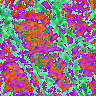

In [15]:
tvf.to_pil_image(ds[idx][0][0])

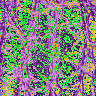

In [16]:
tvf.to_pil_image(ds[idx][0][1])

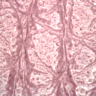

In [17]:
tvf.to_pil_image(ds.raw(idx)[0][1])

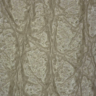

In [18]:
tvf.to_pil_image(ds.raw(idx)[0][0])

# Model

In [19]:
# 1st model, TODO: this model need a name
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

In [20]:
base_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


In [21]:
base_model.classifier.fc.in_features

1280

In [22]:
from efficientnet_pytorch import EfficientNet

ImageEmbedding

In [23]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x

    def __init__(self, base_model = EfficientNet.from_pretrained("efficientnet-b0"), embedding_size=1024):
        super().__init__()
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

Loaded pretrained weights for efficientnet-b0


In [24]:
from torch.multiprocessing import cpu_count
from argparse import Namespace
from torch.optim import RMSprop
hyper_params = Namespace(
    lr=1e-3,
    epochs=50,
    batch_size=64,
    train_size=10000,
    validation_size=1000,
    debug=False
)

ImageEmbeddingModule

In [25]:
# class ImageEmbeddingModule(pl.LightningModule):
#     def __init__(self, hyper_params):
#         hyper_params = Namespace(**hyper_params) if isinstance(hyper_params, dict) else hyper_params
#         super().__init__()
#         self.hyper_params = hyper_params
#         self.model = ImageEmbedding()
#         self.loss = ContrastiveLoss(hyper_params.batch_size)
    
#     def total_steps(self):
#         return len(self.train_dataloader()) // self.hyper_params.epochs
    
#     def train_dataloader(self):
#         return DataLoader(PretrainingDatasetWrapper(train_set),
#                           batch_size=self.hyper_params.batch_size, 
#                           num_workers=cpu_count(),
#                           sampler=SubsetRandomSampler(list(range(hyper_params.train_size))),
#                           drop_last=True)
    
#     def val_dataloader(self):
#         return DataLoader(PretrainingDatasetWrapper(val_set),
#                           batch_size=self.hyper_params.batch_size, 
#                           shuffle=False,
#                           num_workers=cpu_count(),
#                           sampler=SequentialSampler(list(range(hyper_params.train_size + 1, hyper_params.train_size + hyper_params.validation_size))),
#                           drop_last=True)
    
#     def forward(self, X):
#         return self.model(X)
    
#     def step(self, batch, step_name = "train"):
#         (t1, t2), y = batch
#         emb_t1, proj_t1 = self.forward(t1)
#         emb_t2, proj_t2 = self.forward(t2)
#         loss = self.loss(proj_t1, proj_t2)
#         loss_key = f"{step_name}_loss"
#         tensorboard_logs = {loss_key: loss}
#         return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
#                         "progress_bar": {loss_key: loss}}
    
#     def training_step(self, batch):
#         return self.step(batch, "train")
    
#     def validation_step(self, batch):
#         return self.step(batch, "val")
    
#     def validation_end(self, outputs):
#         if len(outputs) == 0:
#             return {"val_loss": torch.tensor(0)}
#         else:
#             loss = torch.stack([x["val_loss"] for x in outputs]).mean()
#             return {"val_loss": loss, "log": {"val_loss": loss}}

#     def configure_optimizers(self):
#         optimizer = RMSprop(self.model.parameters(), lr=self.hyper_params.lr)
#         return [optimizer], []

In [26]:
# module = ImageEmbeddingModule(hyper_params)
# t = pl.Trainer(gpus=1)
# lr_finder = t.tuner.lr_find(module)

In [27]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection


In [28]:
vld_labels = DataLoader(PretrainingDatasetWrapper(val_set, real_labels=True),
                        batch_size=128, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        drop_last=True)

In [29]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_batchnorm = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_batchnorm
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):  # with pretrain
    def __init__(self,base_model,base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer
        
        #PRETRAINED MODEL
        self.pretrained = self.base_model
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(2048, 2048, self.base_out_layer)
    

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

In [30]:
model = ImageEmbedding()
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


plot_feature

In [31]:
from sklearn.manifold import TSNE

def plot_features(model, num_class, num_feats, batch_size, vdl):
    feats = np.empty([0, num_feats])
    labels = np.empty(0, dtype=int)
    model.eval()
    with torch.no_grad():
        for (x1, x2), y  in vdl:
            x1 = x1.squeeze().to(device, dtype = torch.float)
            x1_emb, x1_proj = model(x1)
            x1_proj = x1_proj.cpu().numpy()
            feats = np.append(feats, x1_proj, axis=0)
            labels = np.append(labels, y, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(val_size//batch_size))
    
    plt.figure(figsize=(20, 20))
    for i in range(num_class):
        plt.scatter(x_feats[labels[:num_samples]==i,1],x_feats[labels[:num_samples]==i,0],alpha=0.2)
    plt.legend([str(i) for i in range(num_class)], loc=4, ncol=(num_class + 1) // 2)
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


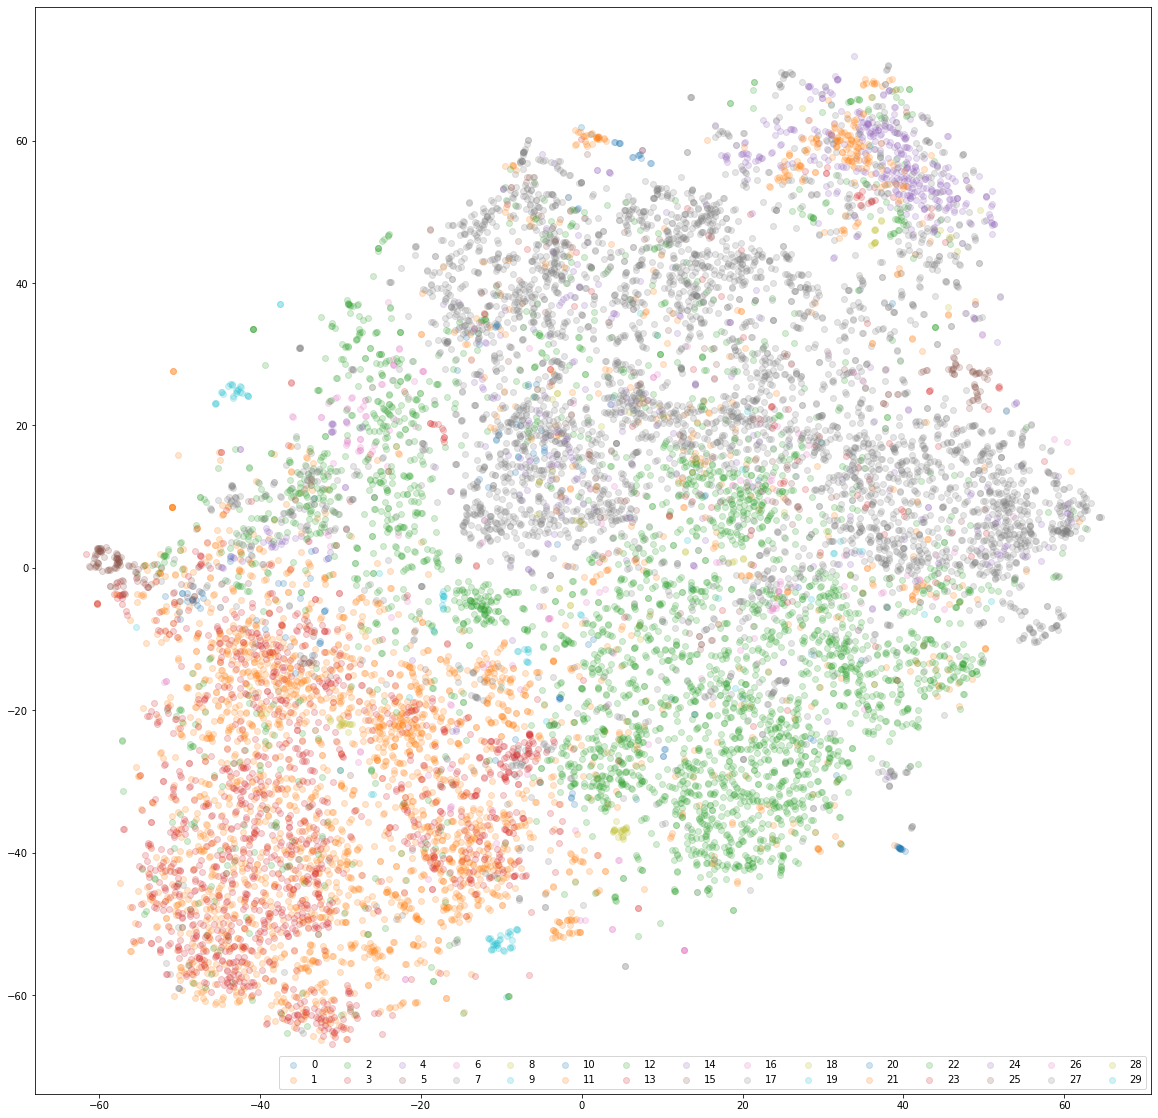

In [32]:
plot_features(model, num_class, 1024, 128, vld_labels)

Train

LARS

In [33]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(self, 
                 params, 
                 lr=required,
                 momentum=0.9,
                 use_nesterov=False,
                 weight_decay=0.0,
                 exclude_from_weight_decay=None,
                 exclude_from_layer_adaptation=None,
                 classic_momentum=True,
                 eeta=EETA_DEFAULT):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """
                
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.epoch = 0
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        self.exclude_from_layer_adaptation = exclude_from_layer_adaptation if exclude_from_layer_adaptation else exclude_from_weight_decay
        
    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

Loader

In [34]:
train_loader = DataLoader(PretrainingDatasetWrapper(train_set),
                        batch_size=128, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        drop_last=True)
#return (t1, t2), labels

optimizer

In [35]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch     0: adjusting learning rate of group 0 to 2.0000e-01.


criterion

In [36]:
criterion = ContrastiveLoss(batch_size = 128, temperature = 0.5)

Train

In [37]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, batch in enumerate(train_loader):
        (t1, t2), _ = batch
        optimizer.zero_grad()
        t1 = t1.squeeze().to(device).float()
        t2 = t2.squeeze().to(device).float()

        # positive pair, with encoding
        t1_emb, t1_proj = model(t1)
        t2_emb, t2_proj = model(t2)

        loss = criterion(t1_proj, t2_proj)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [38]:
# Loss on val loader
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, batch in enumerate(valid_loader):
        (t1, t2), _ = batch
        t1 = t1.squeeze().to(device).float()
        t2 = t2.squeeze().to(device).float()

        # forward
        t1_emb, t1_proj = model(t1)
        t2_emb, t2_proj = model(t2)
        loss = criterion(t1_proj, t2_proj)
        
        if step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [39]:
global_step = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

Epoch [0/100]	


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/python_arg_parser.cpp:1025.)


Step [0/412]	 Loss: 5.42208
Step [50/412]	 Loss: 5.05107
Step [100/412]	 Loss: 4.60423
Step [150/412]	 Loss: 4.42839
Step [200/412]	 Loss: 4.77945
Step [250/412]	 Loss: 4.71551
Step [300/412]	 Loss: 4.41854
Step [350/412]	 Loss: 4.5229
Step [400/412]	 Loss: 4.57517
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/103]	 Loss: 4.82185
Step [50/103]	 Loss: 5.29967
Step [100/103]	 Loss: 4.33632
Epoch [0/100]	 Training Loss: 4.637376557276087	 lr: 0.04
Epoch [0/100]	 Validation Loss: 4.792205972578919	 lr: 0.04
Epoch [0/100]	 Time Taken: 4.778400774796804 minutes
Epoch [1/100]	
Step [0/412]	 Loss: 4.2716
Step [50/412]	 Loss: 4.43484
Step [100/412]	 Loss: 4.37217
Step [150/412]	 Loss: 4.37637
Step [200/412]	 Loss: 4.56782
Step [250/412]	 Loss: 4.51504
Step [300/412]	 Loss: 4.38347
Step [350/412]	 Loss: 4.42985
Step [400/412]	 Loss: 4.474
Adjusting learning rate of group 0 to 6.0000e-02.
Step [0/103]	 Loss: 4.67751
Step [50/103]	 Loss: 5.11187
Step [100/103]	 Loss: 4.30615
Epoch [1/1

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


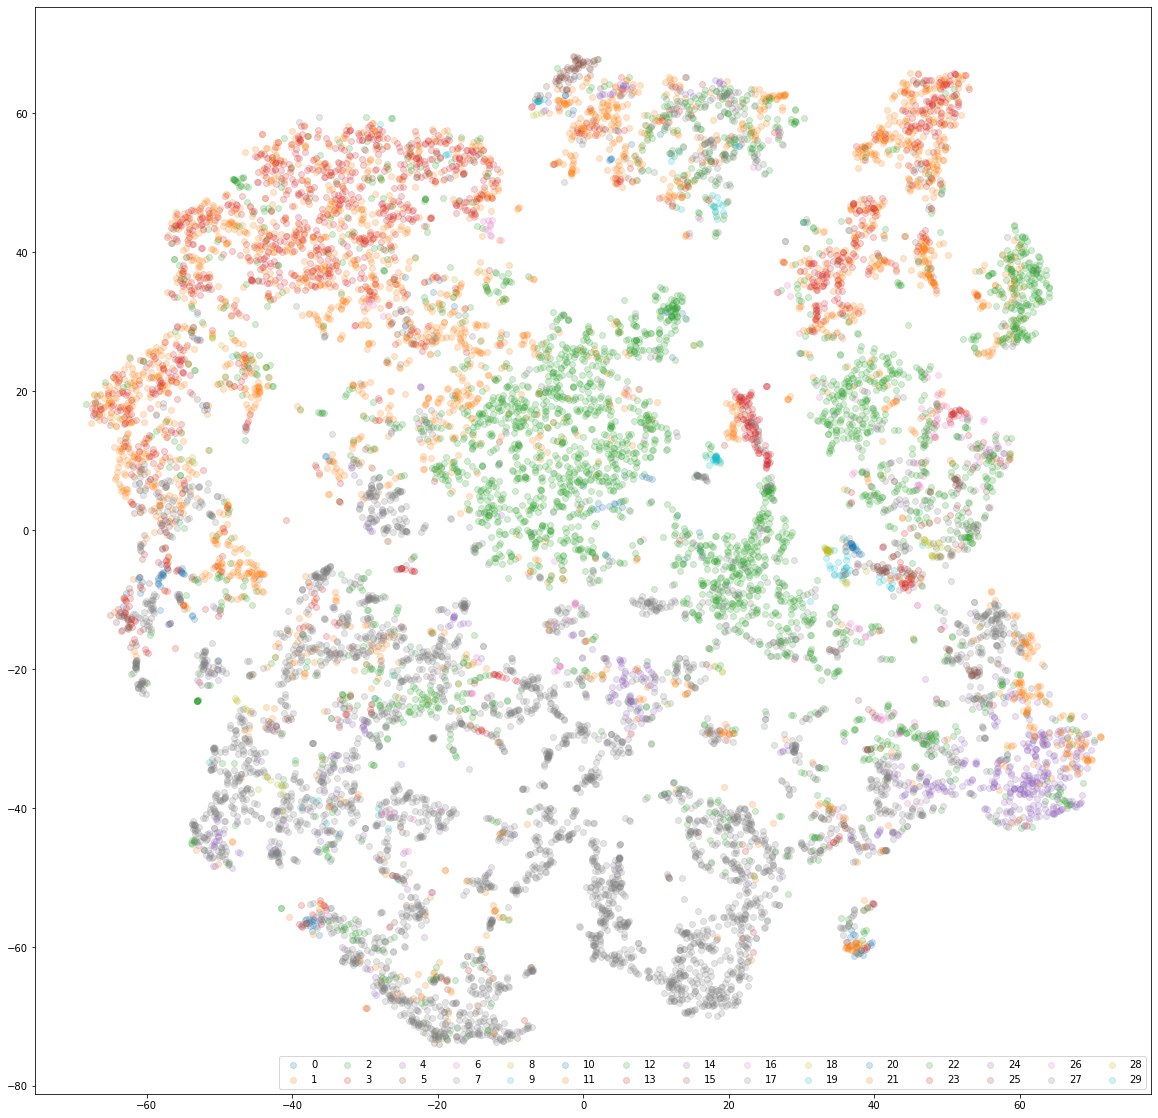

Epoch [10/100]	
Step [0/412]	 Loss: 4.14058
Step [50/412]	 Loss: 4.19568
Step [100/412]	 Loss: 4.24073
Step [150/412]	 Loss: 4.05769
Step [200/412]	 Loss: 4.34688
Step [250/412]	 Loss: 4.221
Step [300/412]	 Loss: 4.23703
Step [350/412]	 Loss: 4.25197
Step [400/412]	 Loss: 4.33554
Epoch     1: adjusting learning rate of group 0 to 2.0000e-01.
Step [0/103]	 Loss: 4.64712
Step [50/103]	 Loss: 5.09524
Step [100/103]	 Loss: 4.26865
Epoch [10/100]	 Training Loss: 4.18700396435932	 lr: 0.2
Epoch [10/100]	 Validation Loss: 4.662078440768047	 lr: 0.2
Epoch [10/100]	 Time Taken: 4.741825250784556 minutes
Epoch [11/100]	
Step [0/412]	 Loss: 4.14108
Step [50/412]	 Loss: 4.16578
Step [100/412]	 Loss: 4.24004
Step [150/412]	 Loss: 4.04465
Step [200/412]	 Loss: 4.39043
Step [250/412]	 Loss: 4.24358
Step [300/412]	 Loss: 4.23821
Step [350/412]	 Loss: 4.27757
Step [400/412]	 Loss: 4.30771
Epoch     2: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/103]	 Loss: 4.5686
Step [50/103]	 Loss: 5.04

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


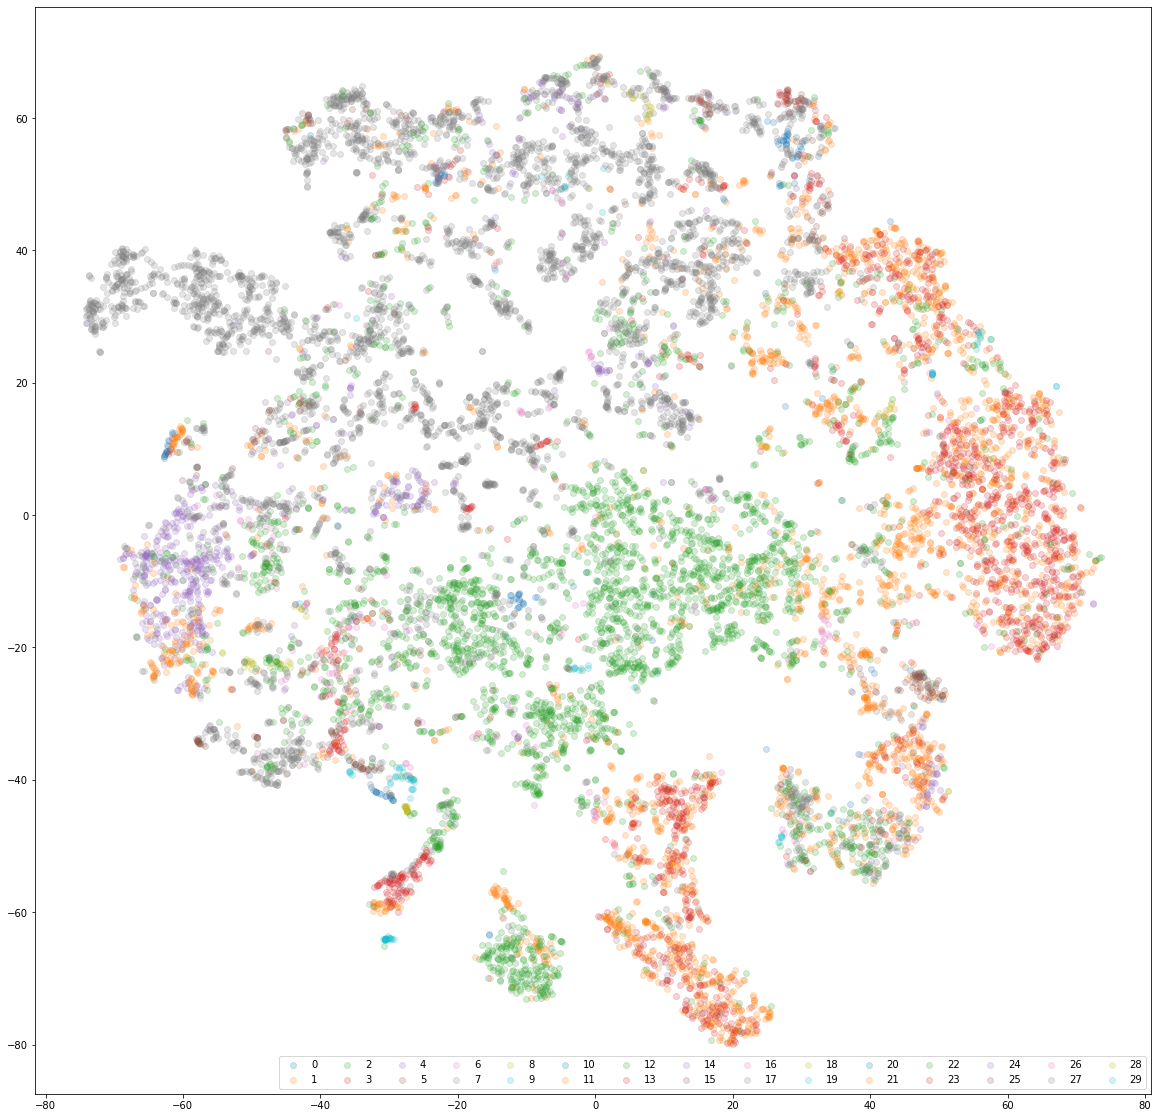

Epoch [20/100]	
Step [0/412]	 Loss: 4.08885
Step [50/412]	 Loss: 4.1039
Step [100/412]	 Loss: 4.21076
Step [150/412]	 Loss: 3.95496
Step [200/412]	 Loss: 4.1931
Step [250/412]	 Loss: 4.11829
Step [300/412]	 Loss: 4.20574
Step [350/412]	 Loss: 4.21238
Step [400/412]	 Loss: 4.29202
Epoch    11: adjusting learning rate of group 0 to 1.9982e-01.
Step [0/103]	 Loss: 4.47866
Step [50/103]	 Loss: 4.94644
Step [100/103]	 Loss: 4.2268
Epoch [20/100]	 Training Loss: 4.10684295707536	 lr: 0.19982
Epoch [20/100]	 Validation Loss: 4.597461968949697	 lr: 0.19982
Epoch [20/100]	 Time Taken: 4.739881380399068 minutes
Epoch [21/100]	
Step [0/412]	 Loss: 4.06654
Step [50/412]	 Loss: 4.1216
Step [100/412]	 Loss: 4.17767
Step [150/412]	 Loss: 3.95288
Step [200/412]	 Loss: 4.21609
Step [250/412]	 Loss: 4.19691
Step [300/412]	 Loss: 4.21186
Step [350/412]	 Loss: 4.17134
Step [400/412]	 Loss: 4.26747
Epoch    12: adjusting learning rate of group 0 to 1.9979e-01.
Step [0/103]	 Loss: 4.51632
Step [50/103]	 Los

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


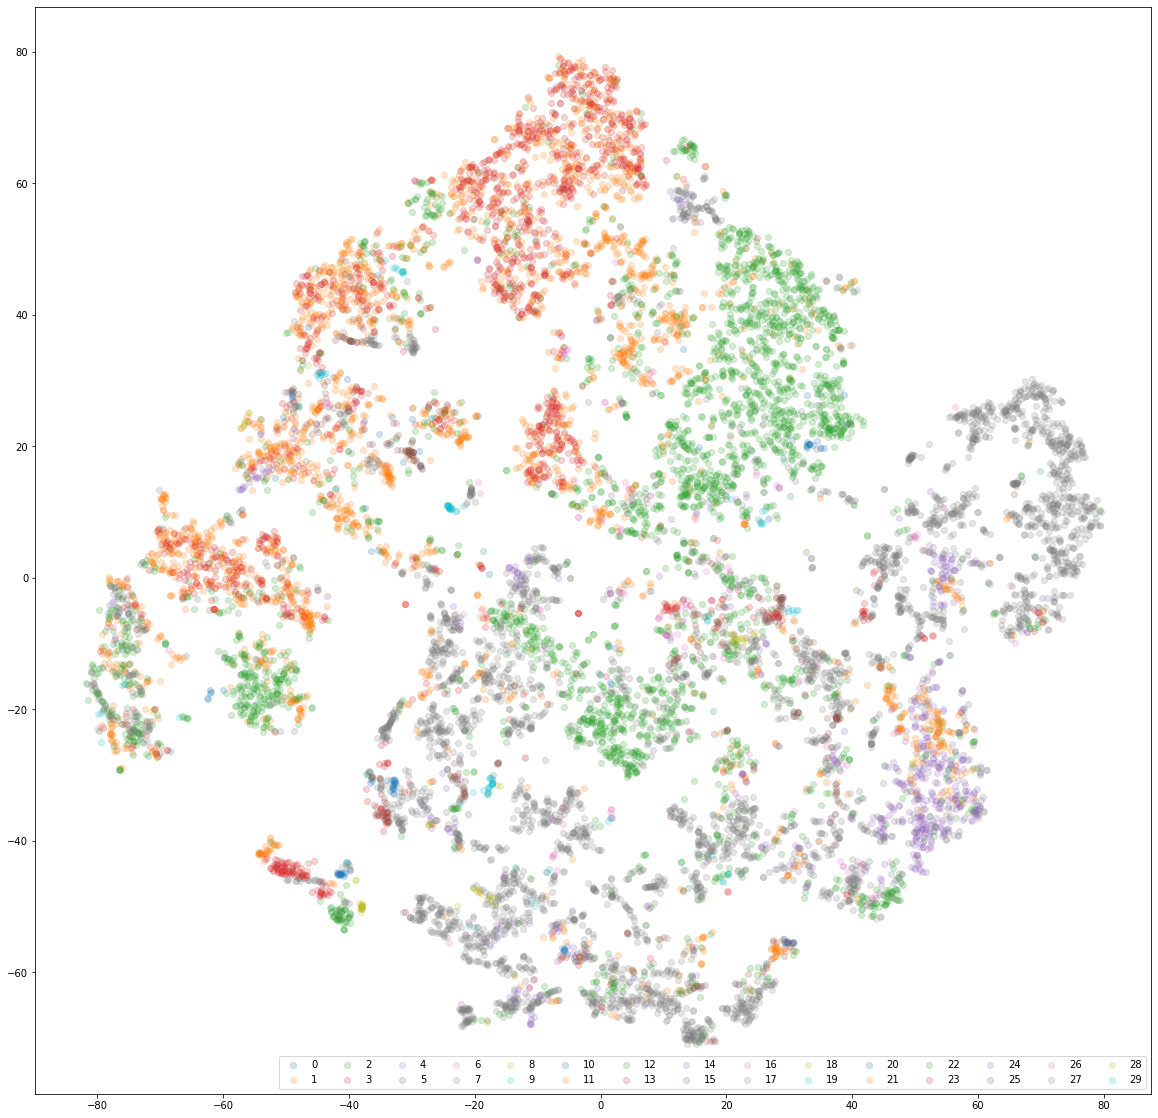

Epoch [30/100]	
Step [0/412]	 Loss: 4.0737
Step [50/412]	 Loss: 4.07276
Step [100/412]	 Loss: 4.16139
Step [150/412]	 Loss: 3.91697
Step [200/412]	 Loss: 4.09974
Step [250/412]	 Loss: 4.10942
Step [300/412]	 Loss: 4.16865
Step [350/412]	 Loss: 4.19064
Step [400/412]	 Loss: 4.19569
Epoch    21: adjusting learning rate of group 0 to 1.9935e-01.
Step [0/103]	 Loss: 4.51934
Step [50/103]	 Loss: 4.92154
Step [100/103]	 Loss: 4.24579
Epoch [30/100]	 Training Loss: 4.065995385345904	 lr: 0.19935
Epoch [30/100]	 Validation Loss: 4.573297009884732	 lr: 0.19935
Epoch [30/100]	 Time Taken: 4.756862338383993 minutes
Epoch [31/100]	
Step [0/412]	 Loss: 4.05109
Step [50/412]	 Loss: 4.05003
Step [100/412]	 Loss: 4.12887
Step [150/412]	 Loss: 3.92579
Step [200/412]	 Loss: 4.085
Step [250/412]	 Loss: 4.07937
Step [300/412]	 Loss: 4.17532
Step [350/412]	 Loss: 4.14093
Step [400/412]	 Loss: 4.18829
Epoch    22: adjusting learning rate of group 0 to 1.9928e-01.
Step [0/103]	 Loss: 4.43943
Step [50/103]	 L

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


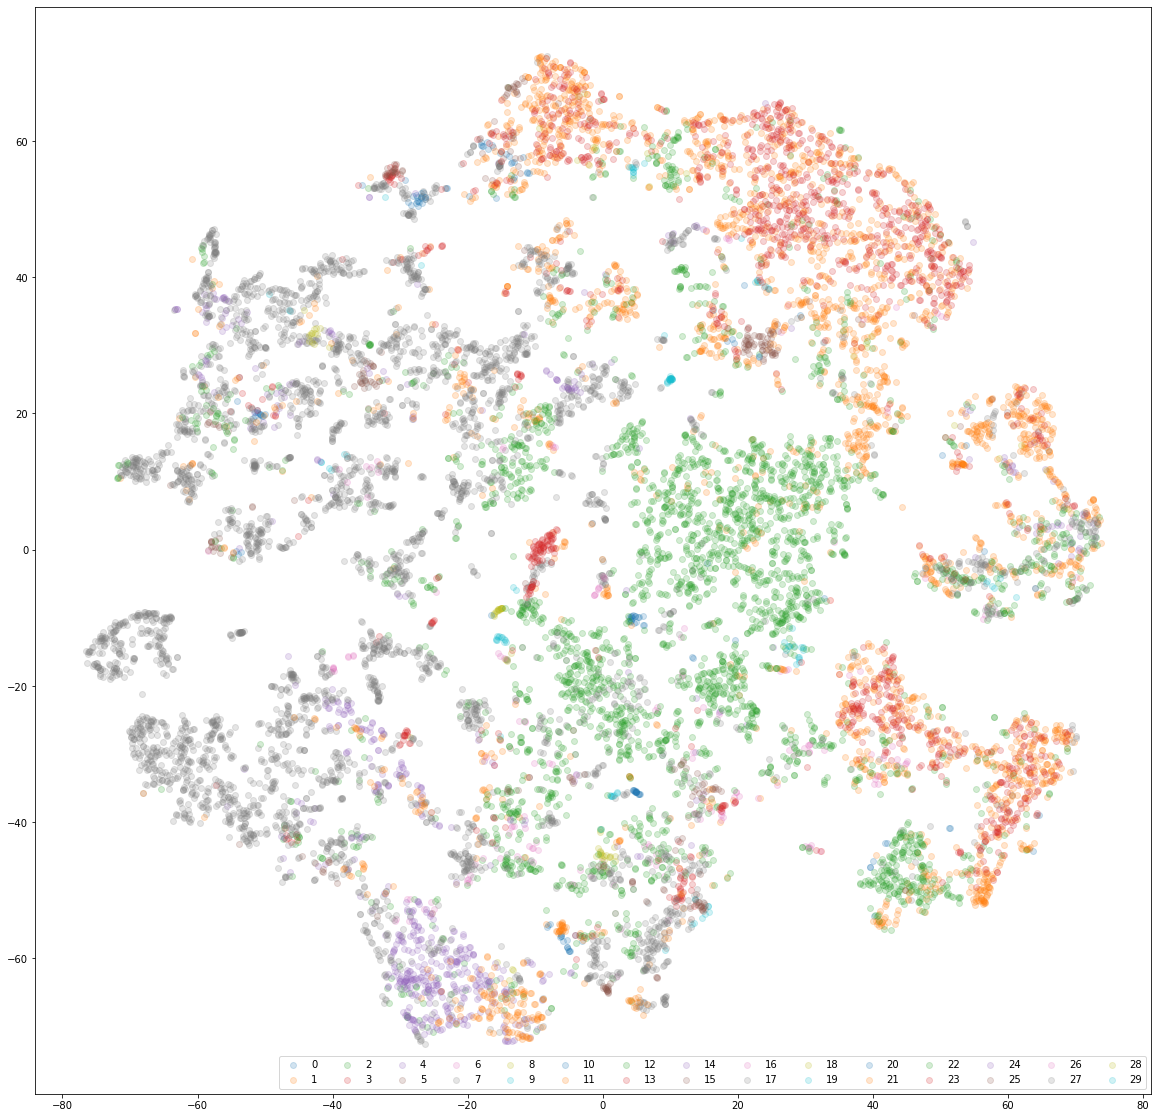

Epoch [40/100]	
Step [0/412]	 Loss: 4.03133
Step [50/412]	 Loss: 4.05814
Step [100/412]	 Loss: 4.11135
Step [150/412]	 Loss: 3.91652
Step [200/412]	 Loss: 4.02232
Step [250/412]	 Loss: 4.1088
Step [300/412]	 Loss: 4.14452
Step [350/412]	 Loss: 4.14766
Step [400/412]	 Loss: 4.14263
Epoch    31: adjusting learning rate of group 0 to 1.9858e-01.
Step [0/103]	 Loss: 4.42899
Step [50/103]	 Loss: 4.92026
Step [100/103]	 Loss: 4.22339
Epoch [40/100]	 Training Loss: 4.03466606660954	 lr: 0.19858
Epoch [40/100]	 Validation Loss: 4.5629030986896995	 lr: 0.19858
Epoch [40/100]	 Time Taken: 4.750445290406545 minutes
Epoch [41/100]	
Step [0/412]	 Loss: 3.99229
Step [50/412]	 Loss: 4.0569
Step [100/412]	 Loss: 4.08075
Step [150/412]	 Loss: 3.91197
Step [200/412]	 Loss: 4.01392
Step [250/412]	 Loss: 4.06395
Step [300/412]	 Loss: 4.09825
Step [350/412]	 Loss: 4.14407
Step [400/412]	 Loss: 4.15255
Epoch    32: adjusting learning rate of group 0 to 1.9849e-01.
Step [0/103]	 Loss: 4.43467
Step [50/103]	 

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


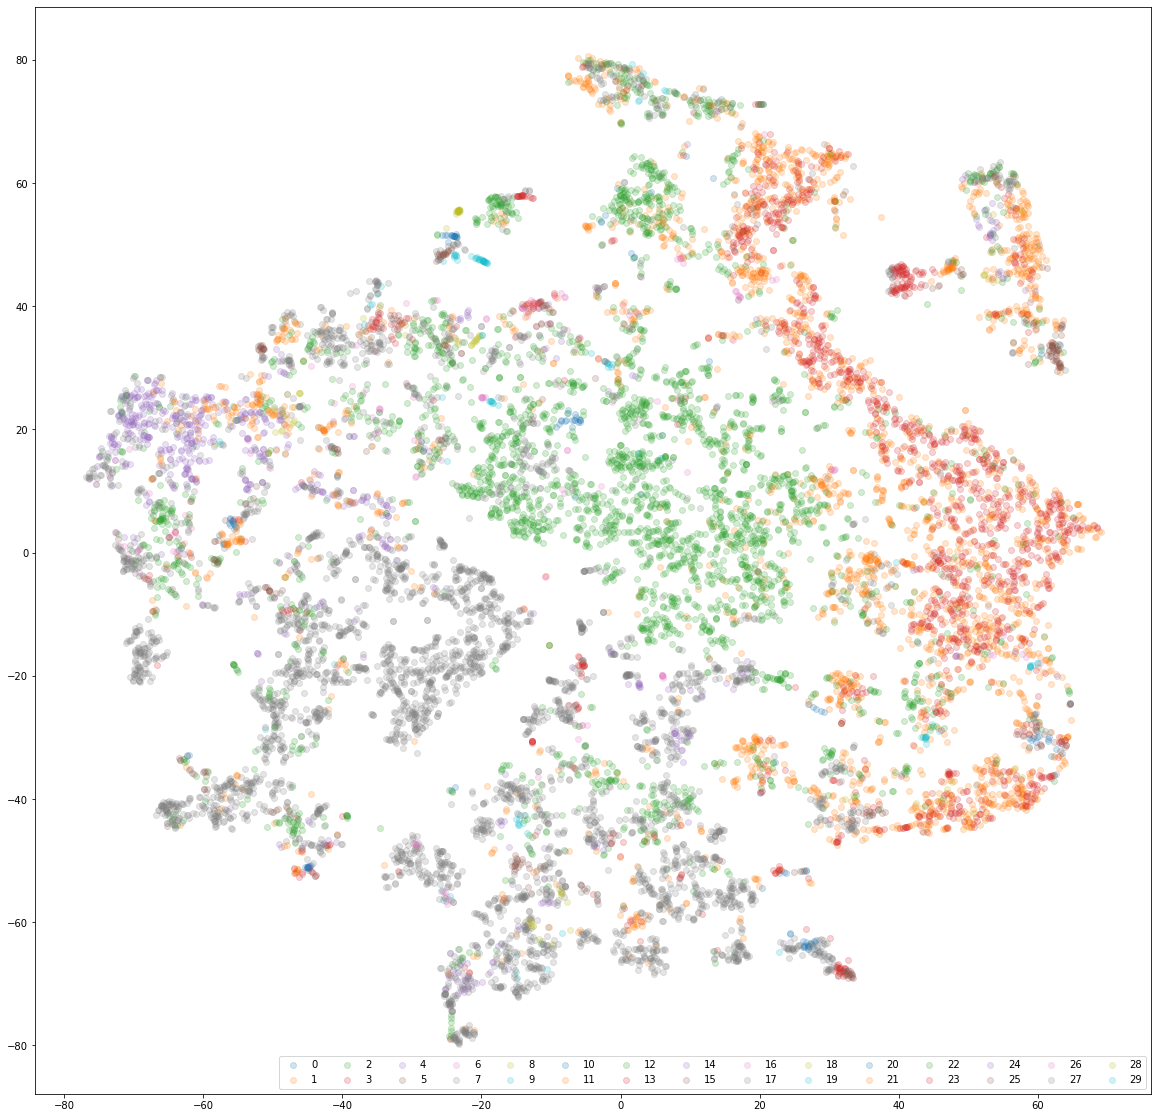

Epoch [50/100]	
Step [0/412]	 Loss: 3.98816
Step [50/412]	 Loss: 4.03593
Step [100/412]	 Loss: 4.06366
Step [150/412]	 Loss: 3.91436
Step [200/412]	 Loss: 4.03737
Step [250/412]	 Loss: 4.00502
Step [300/412]	 Loss: 4.134
Step [350/412]	 Loss: 4.09579
Step [400/412]	 Loss: 4.15274
Epoch    41: adjusting learning rate of group 0 to 1.9753e-01.
Step [0/103]	 Loss: 4.47472
Step [50/103]	 Loss: 4.97986
Step [100/103]	 Loss: 4.16471
Epoch [50/100]	 Training Loss: 4.0122016199584145	 lr: 0.19753
Epoch [50/100]	 Validation Loss: 4.543355381604537	 lr: 0.19753
Epoch [50/100]	 Time Taken: 4.737569526831309 minutes
Epoch [51/100]	
Step [0/412]	 Loss: 4.00189
Step [50/412]	 Loss: 4.02504
Step [100/412]	 Loss: 4.1083
Step [150/412]	 Loss: 3.88348
Step [200/412]	 Loss: 4.00235
Step [250/412]	 Loss: 4.0288
Step [300/412]	 Loss: 4.08981
Step [350/412]	 Loss: 4.10744
Step [400/412]	 Loss: 4.12907
Epoch    42: adjusting learning rate of group 0 to 1.9740e-01.
Step [0/103]	 Loss: 4.46977
Step [50/103]	 L

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


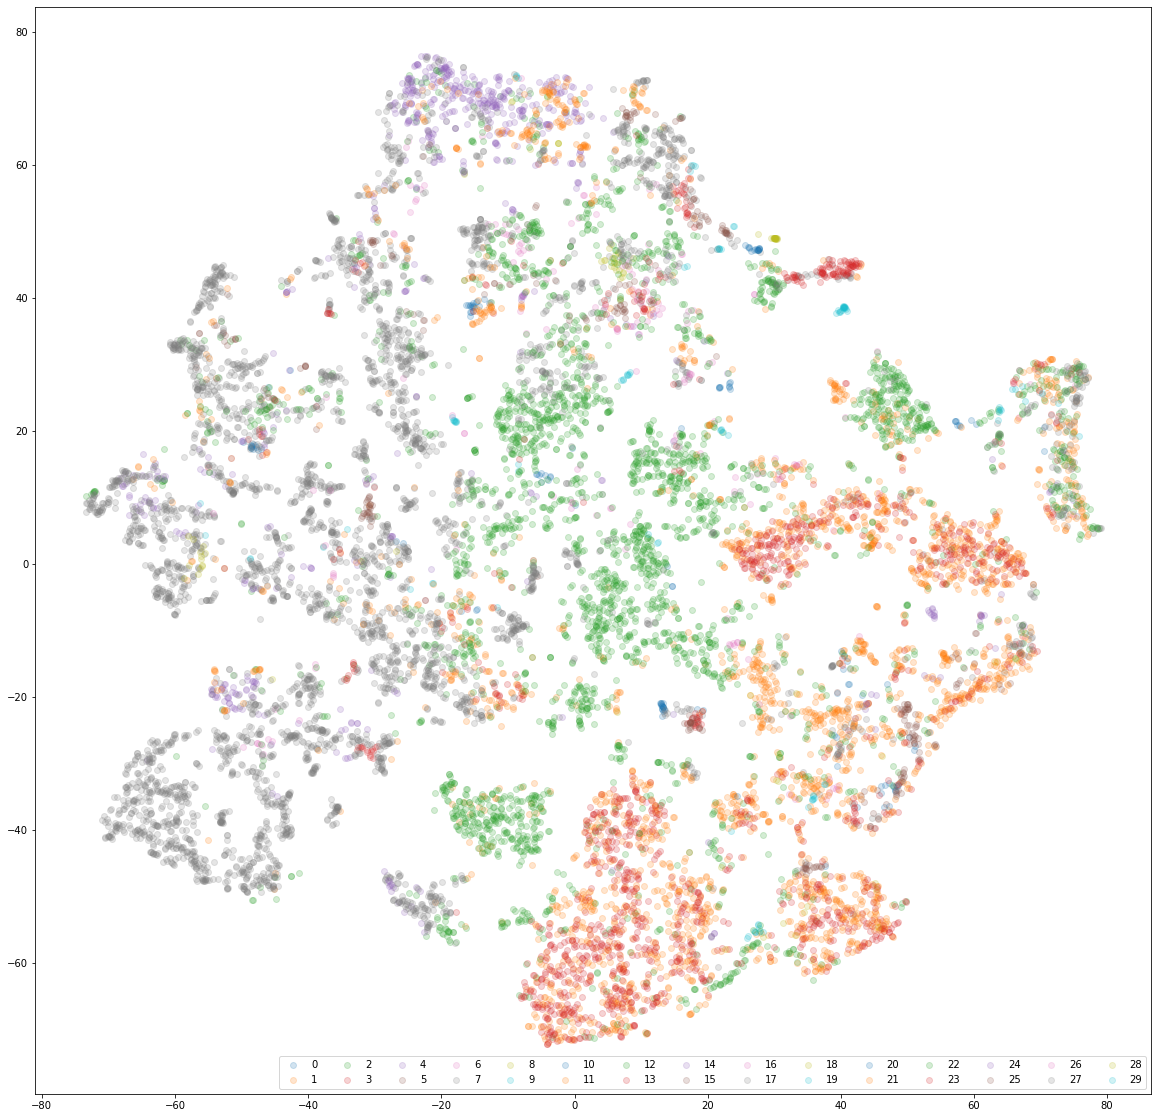

Epoch [60/100]	
Step [0/412]	 Loss: 4.00531
Step [50/412]	 Loss: 4.0234
Step [100/412]	 Loss: 4.04147
Step [150/412]	 Loss: 3.88497
Step [200/412]	 Loss: 4.00937
Step [250/412]	 Loss: 4.05072
Step [300/412]	 Loss: 4.15408
Step [350/412]	 Loss: 4.09548
Step [400/412]	 Loss: 4.08676
Epoch    51: adjusting learning rate of group 0 to 1.9618e-01.
Step [0/103]	 Loss: 4.36425
Step [50/103]	 Loss: 4.78235
Step [100/103]	 Loss: 4.18008
Epoch [60/100]	 Training Loss: 3.994832388405661	 lr: 0.19618
Epoch [60/100]	 Validation Loss: 4.481055954127636	 lr: 0.19618
Epoch [60/100]	 Time Taken: 4.763271109263102 minutes
Epoch [61/100]	
Step [0/412]	 Loss: 3.99404
Step [50/412]	 Loss: 3.99978
Step [100/412]	 Loss: 4.05316
Step [150/412]	 Loss: 3.88117
Step [200/412]	 Loss: 3.99013
Step [250/412]	 Loss: 4.02902
Step [300/412]	 Loss: 4.08528
Step [350/412]	 Loss: 4.11438
Step [400/412]	 Loss: 4.09521
Epoch    52: adjusting learning rate of group 0 to 1.9603e-01.
Step [0/103]	 Loss: 4.37169
Step [50/103]	

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


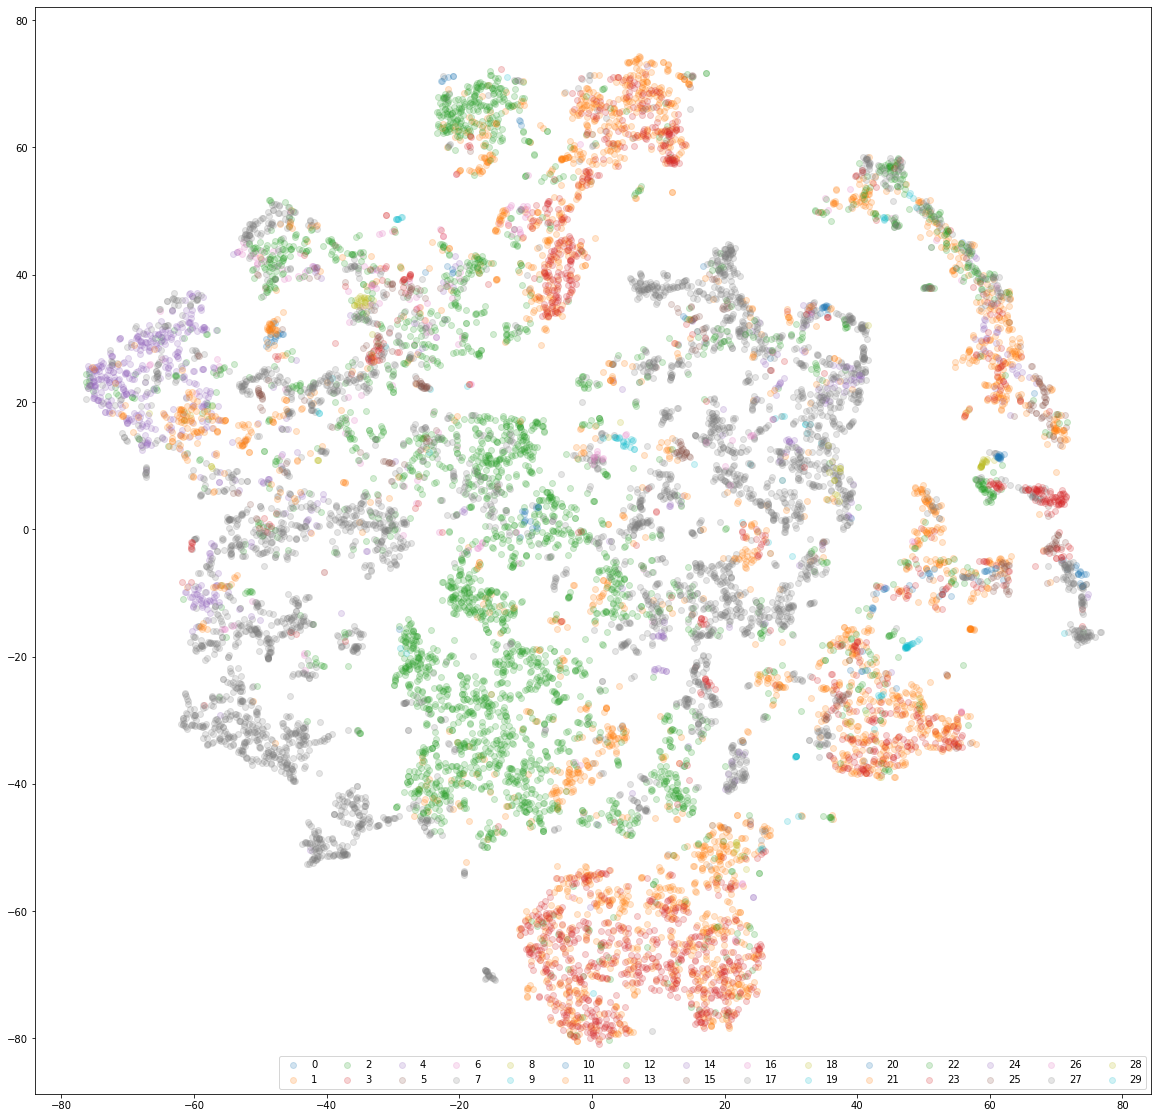

Epoch [70/100]	
Step [0/412]	 Loss: 3.99338
Step [50/412]	 Loss: 3.99075
Step [100/412]	 Loss: 4.02582
Step [150/412]	 Loss: 3.85408
Step [200/412]	 Loss: 3.95039
Step [250/412]	 Loss: 4.03928
Step [300/412]	 Loss: 4.08434
Step [350/412]	 Loss: 4.08204
Step [400/412]	 Loss: 4.1095
Epoch    61: adjusting learning rate of group 0 to 1.9456e-01.
Step [0/103]	 Loss: 4.50469
Step [50/103]	 Loss: 4.83752
Step [100/103]	 Loss: 4.22407
Epoch [70/100]	 Training Loss: 3.977613235561593	 lr: 0.19456
Epoch [70/100]	 Validation Loss: 4.467601827047403	 lr: 0.19456
Epoch [70/100]	 Time Taken: 4.754783058166504 minutes
Epoch [71/100]	
Step [0/412]	 Loss: 3.97916
Step [50/412]	 Loss: 3.97285
Step [100/412]	 Loss: 4.03526
Step [150/412]	 Loss: 3.86747
Step [200/412]	 Loss: 3.99147
Step [250/412]	 Loss: 3.98885
Step [300/412]	 Loss: 4.05223
Step [350/412]	 Loss: 4.09936
Step [400/412]	 Loss: 4.09532
Epoch    62: adjusting learning rate of group 0 to 1.9438e-01.
Step [0/103]	 Loss: 4.39289
Step [50/103]	

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


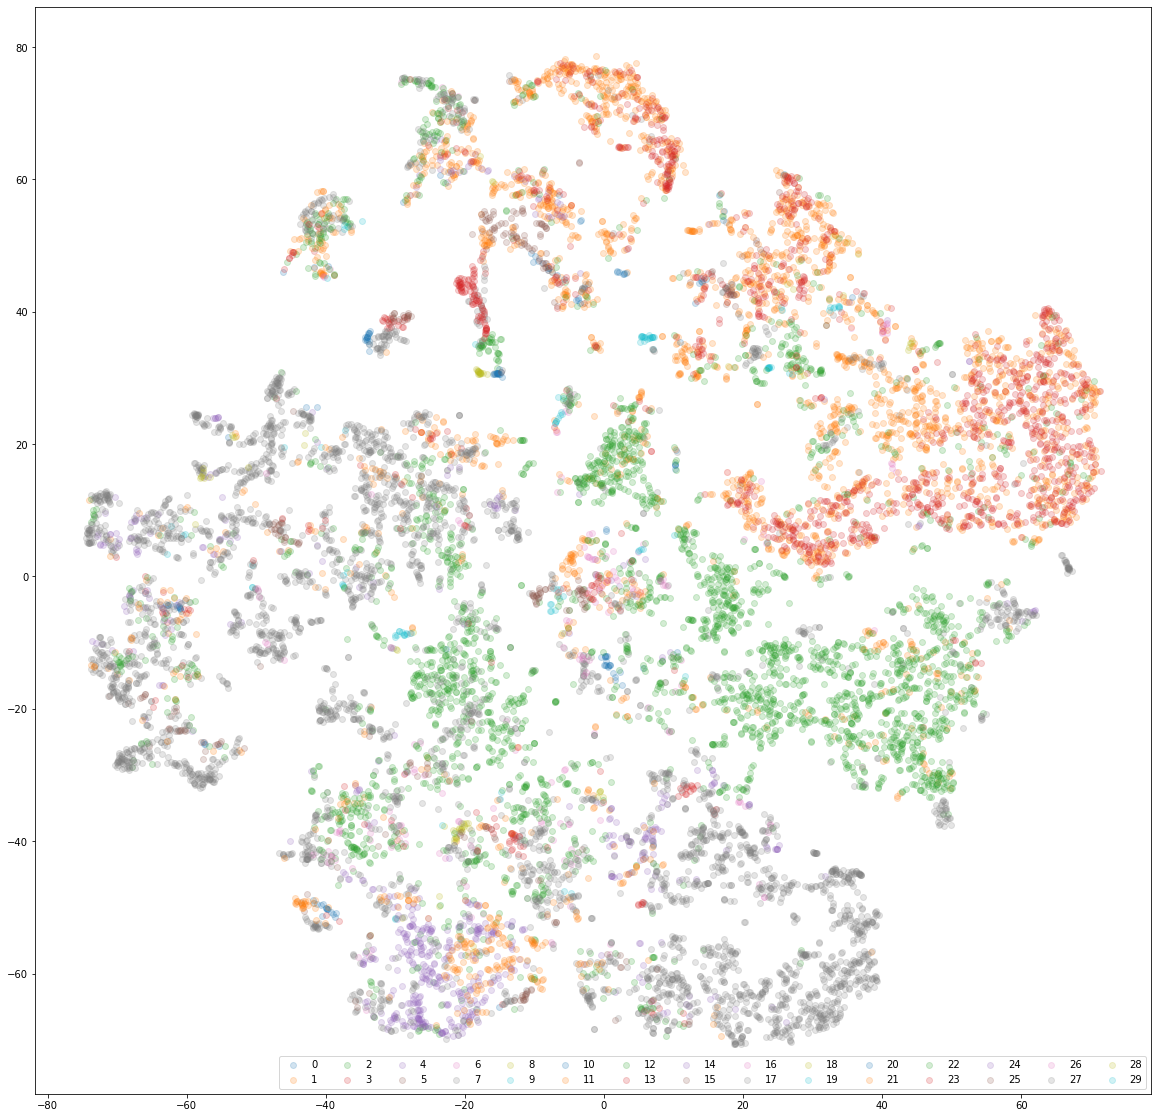

Epoch [80/100]	
Step [0/412]	 Loss: 3.98809
Step [50/412]	 Loss: 3.99574
Step [100/412]	 Loss: 3.99206
Step [150/412]	 Loss: 3.86482
Step [200/412]	 Loss: 3.98166
Step [250/412]	 Loss: 4.03347
Step [300/412]	 Loss: 4.09904
Step [350/412]	 Loss: 4.06687
Step [400/412]	 Loss: 4.05949
Epoch    71: adjusting learning rate of group 0 to 1.9266e-01.
Step [0/103]	 Loss: 4.45099
Step [50/103]	 Loss: 4.87963
Step [100/103]	 Loss: 4.18718
Epoch [80/100]	 Training Loss: 3.966865477631393	 lr: 0.19266
Epoch [80/100]	 Validation Loss: 4.485389390038055	 lr: 0.19266
Epoch [80/100]	 Time Taken: 4.774077014128367 minutes
Epoch [81/100]	
Step [0/412]	 Loss: 3.97051
Step [50/412]	 Loss: 3.9986
Step [100/412]	 Loss: 4.037
Step [150/412]	 Loss: 3.87256
Step [200/412]	 Loss: 3.95949
Step [250/412]	 Loss: 4.05048
Step [300/412]	 Loss: 4.05281
Step [350/412]	 Loss: 4.07717
Step [400/412]	 Loss: 4.08109
Epoch    72: adjusting learning rate of group 0 to 1.9246e-01.
Step [0/103]	 Loss: 4.43307
Step [50/103]	 L

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


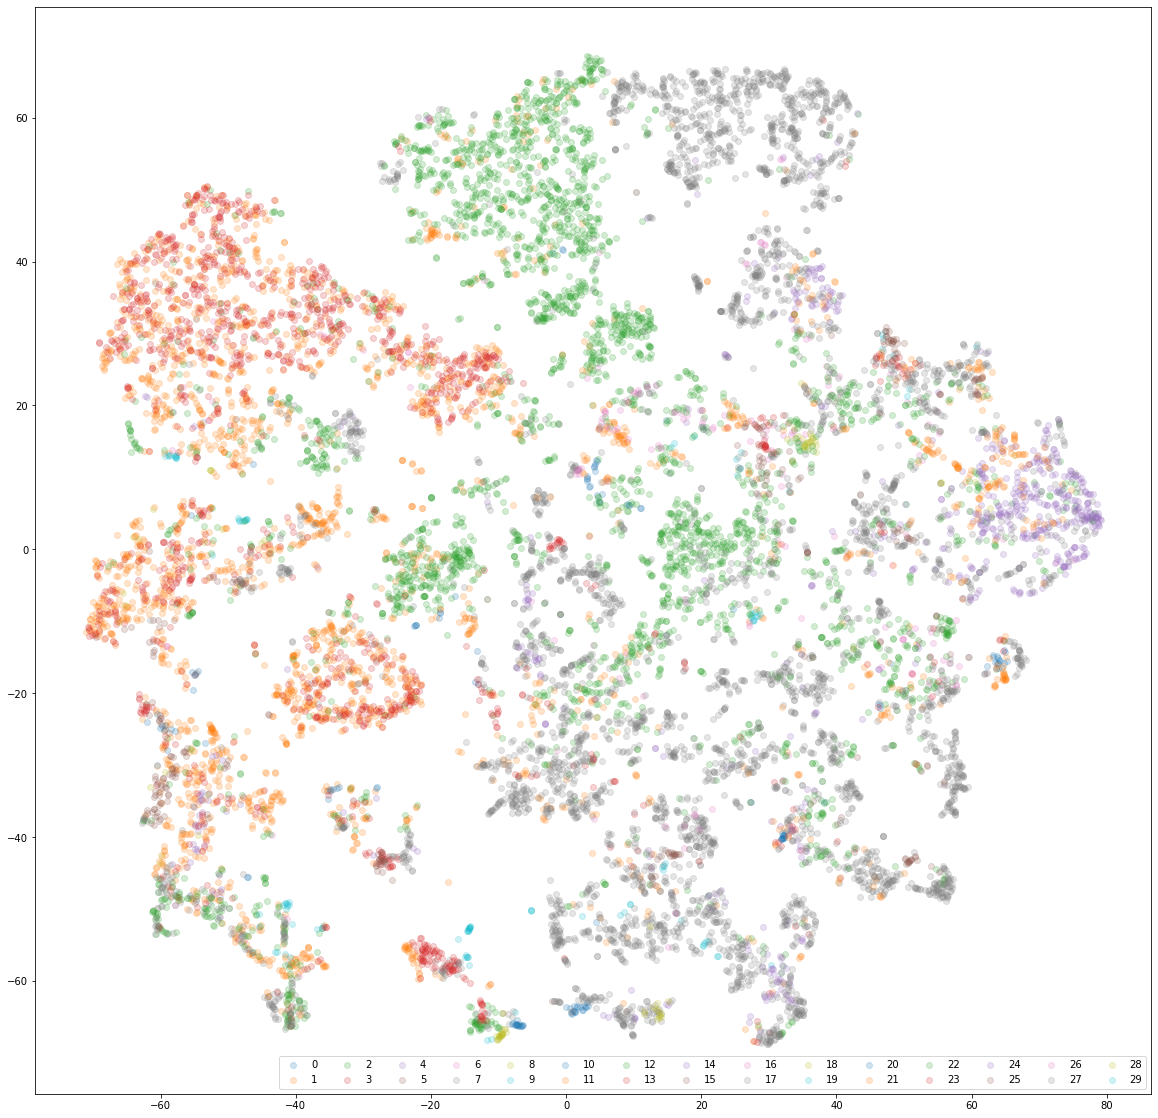

Epoch [90/100]	
Step [0/412]	 Loss: 3.95267
Step [50/412]	 Loss: 3.98613
Step [100/412]	 Loss: 4.00024
Step [150/412]	 Loss: 3.84013
Step [200/412]	 Loss: 3.94606
Step [250/412]	 Loss: 4.00837
Step [300/412]	 Loss: 4.0767
Step [350/412]	 Loss: 4.06011
Step [400/412]	 Loss: 4.05988
Epoch    81: adjusting learning rate of group 0 to 1.9049e-01.
Step [0/103]	 Loss: 4.37294
Step [50/103]	 Loss: 4.76119
Step [100/103]	 Loss: 4.17443
Epoch [90/100]	 Training Loss: 3.954011969195986	 lr: 0.19049
Epoch [90/100]	 Validation Loss: 4.46797761639345	 lr: 0.19049
Epoch [90/100]	 Time Taken: 4.771620893478394 minutes
Epoch [91/100]	
Step [0/412]	 Loss: 3.95471
Step [50/412]	 Loss: 3.98063
Step [100/412]	 Loss: 4.02877
Step [150/412]	 Loss: 3.86012
Step [200/412]	 Loss: 3.90712
Step [250/412]	 Loss: 4.01728
Step [300/412]	 Loss: 4.05601
Step [350/412]	 Loss: 4.03385
Step [400/412]	 Loss: 4.06751
Epoch    82: adjusting learning rate of group 0 to 1.9026e-01.
Step [0/103]	 Loss: 4.40811
Step [50/103]	 

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


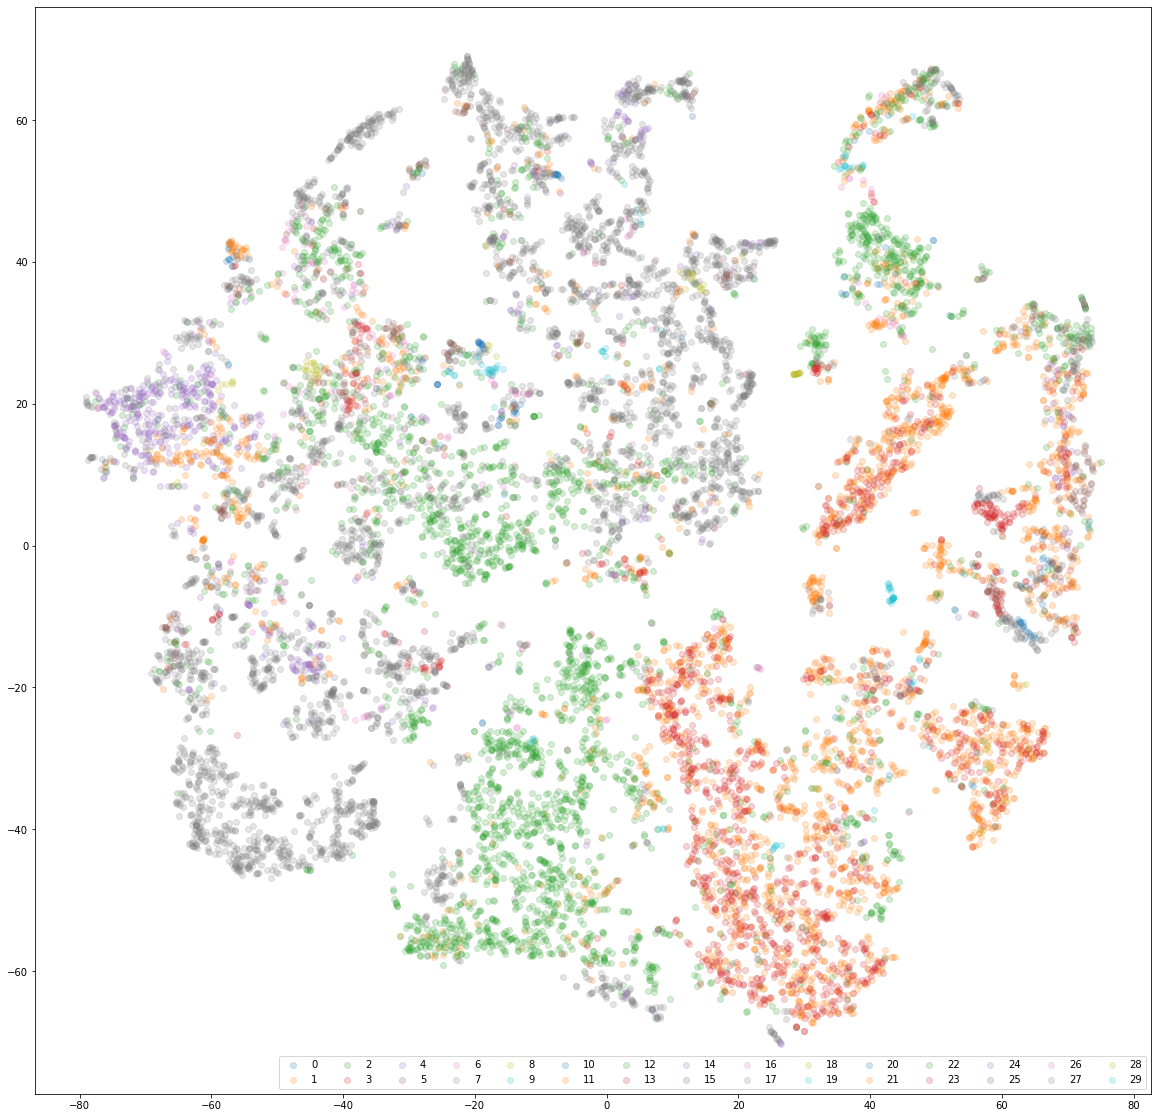

In [40]:
epochs = 100
for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    start_time = time.time()

    model.train()
    train_loss_epoch = train(train_loader, model, criterion, optimizer)

    if epoch < 10:
        warmupscheduler.step()
    if epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if (epoch+1) % 100 == 0:
        print("save_model")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vld_labels, model, criterion)

    tr_loss.append(train_loss_epoch / len(train_loader))
    val_loss.append(val_loss_epoch / len(vld_labels))
    print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {train_loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
    print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vld_labels)}\t lr: {round(lr, 5)}")
    current_epoch += 1

    # dg.on_epoch_end()

    time_taken = (time.time() - start_time)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model, num_class, 1024, 128, vld_labels)

## end training
# save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

In [41]:
# Save model parameters
params_path = "exp/params"
torch.save(model.state_dict(), params_path)